In this document, I will analyze the Kaggle dataset [Medical Cost Personal Dataset](https://www.kaggle.com/mirichoi0218/insurance), trying to predict the medical cost of each person in USA.

#Initial imports

In [1]:
!pip install --upgrade pip setuptools==57.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
arviz 0.20.0 requires setuptools>=60.0.0, but you have setuptools 57.5.0 which is incompatible.
pytensor 2.26.3 requires setuptools>=59.0.0, but you have setuptools 57.5.0 which is incompatible.


In [1]:
!pip install regressors

  Preparing metadata (setup.py) ... done
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12397 sha256=d464dd5f02f488947e2b0d972c065fd8238426c66c17a4f0444c4e80f15adbb0
  Stored in directory: /root/.cache/pip/wheels/85/e8/ec/b8fe5e2d41af2f4760b0d8ce1ae8f01c78df5d1b0883dee2fe
Successfully built regressors


In [2]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

#Import my own functions to ease the process
#sys.path.append('/kaggle/input/utils-regression')
import utils as my_utils

# Understanding the datast

In [3]:
df = pd.read_csv('insurance.csv')
my_utils.get_columns_info(df)
numerical_cols, categorical_cols = my_utils.split_numerical_categorical_cols(df)
df.head()

Shape ->  (1338, 7)
Null values (number) per column ->  age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Null values per column ->  age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

Numerical Summary:          DataType        Min          Max
age         int64    18.0000     64.00000
bmi       float64    15.9600     53.13000
children    int64     0.0000      5.00000
charges   float64  1121.8739  63770.42801

Categorical Summary:        DataType                                        Unique
sex      object                                [female, male]
smoker   object                                     [yes, no]
region   object  [southwest, southeast, northwest, northeast]

Outliers:

There are 0 outlayers in the column age with the next indexs: []
There are 9 outlayers in the column bmi with the next indexs: [1088, 1317, 847, 401, 116, 1

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
my_utils.detect_and_delete_duplicated(df, only_info=True)

Number of duplicate rows: 1


In [5]:
df = my_utils.detect_and_delete_duplicated(df)
df.info()
df.isnull().sum()

Number of duplicate rows: 1
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [6]:
for col in categorical_cols:
  print('Range count ->', df[col].value_counts())

Range count -> sex
male      675
female    662
Name: count, dtype: int64
Range count -> smoker
no     1063
yes     274
Name: count, dtype: int64
Range count -> region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


## Initial context, observations and information

Initial columns and a brief description:
- Age (*int, range -> from 18 to 64* ): beneficiary's years
- Sex (*categorical -> male, female* ): beneficiary's sex
- BMI: (*float, range -> from 15.96 to 53.13* ): beneficiary's objective index of body weight (kg/m^2) using the ratio of height to weight
- Children (*int, range -> from 0 to 5* ): beneficiary's number of children
- Smoker (*categorical -> yes, no* ): if beneficary smokes or not
- Region: (*categorical -> southwest, southeast, northwest, northeast* ) beneficiary's residential area in the US
- Charges (*float, from 1121.87 to 67700.42* ): individual medical costs billed by health insurance

Initial observations:
- There is no null or empty values in any column
- There is only one duplicate row, it will be ommited
- For preprocessing part: It seems not to be necessary normalize or scale any data and we need to encoding some columns
- Sex has a balanced quantity of entries between 'male' and 'female'
- Smoker is highly unbalanced, having much more entries for non-smokers
- Region is relatively balanced, having a slightly more entries for southweast region

# Exploratory Data Analysis

## Main information and distribution of each variable

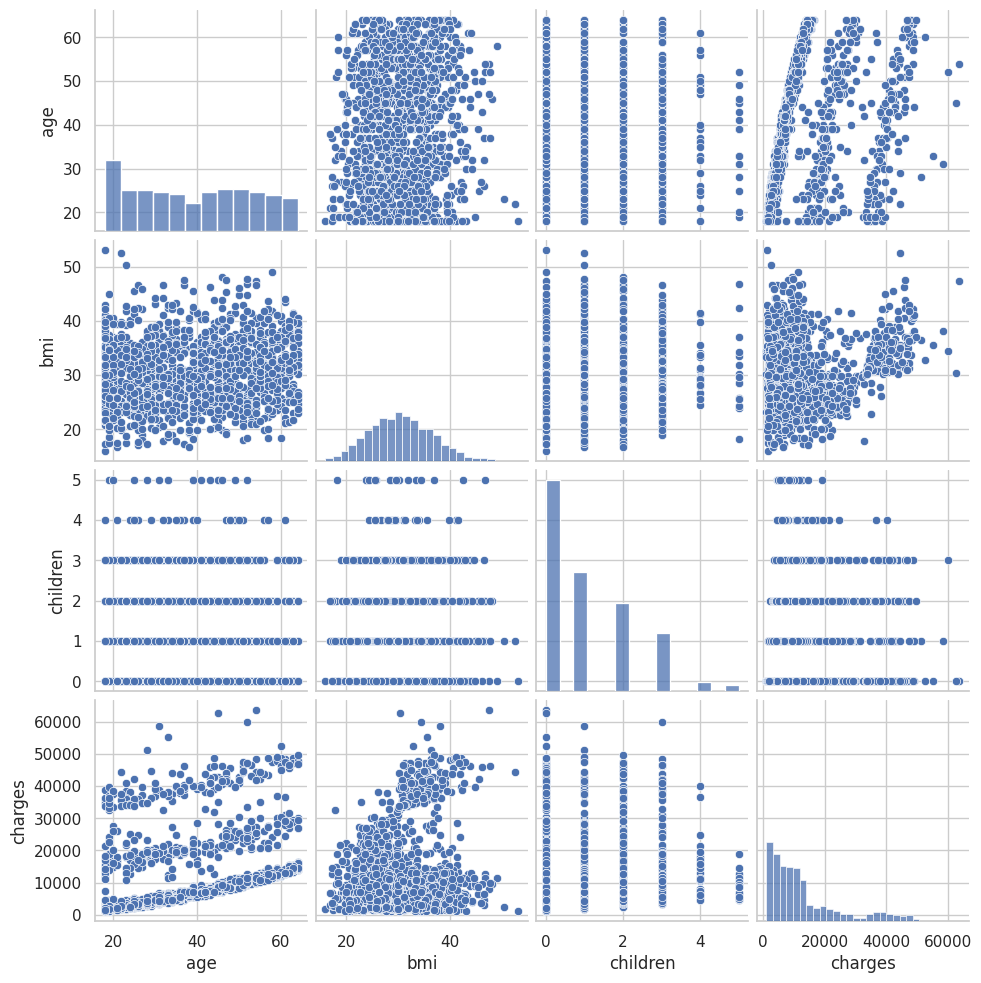

In [7]:
sns.pairplot(df, height=2.5)
plt.show()

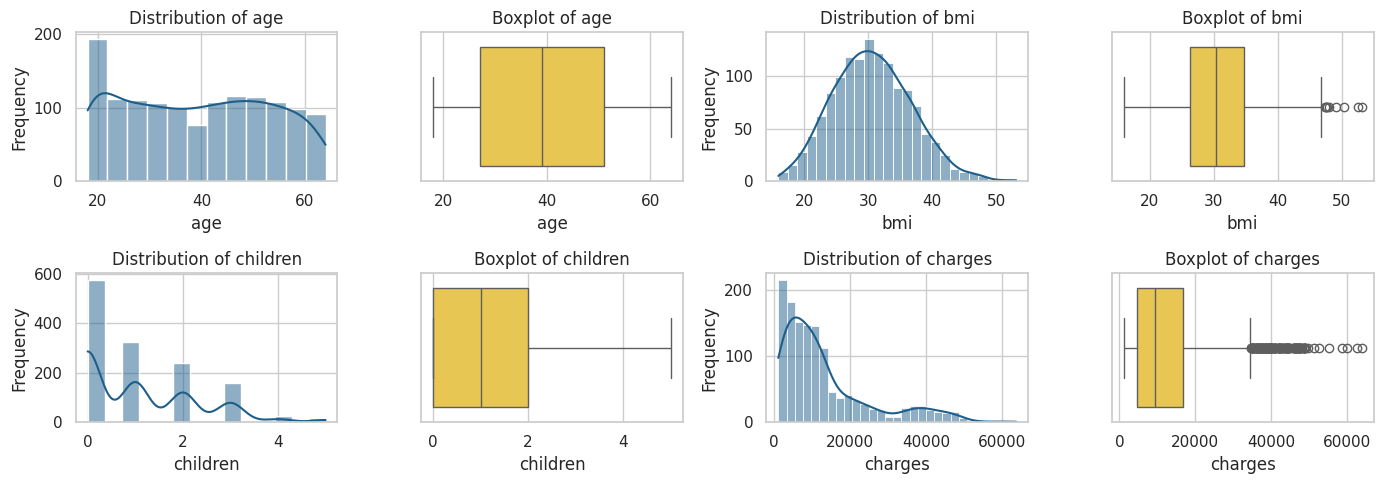

In [8]:
my_utils.plot_numerical_distributions(df)

In [9]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


## Conclusions for this part
- Pair age/charges has three different groups highly marked.
- Age seems to be normal in both distribution and boxplot.
- BMI has a Gaussian distribution with a peak near 30, with a few number of outliers.
- Most policyholders have 0 to 2 children, with fewer having 3 or more.
- Charges distribution is highly right-skewed, with most charges clustered and a long tail of higher charges. There are also a lot of outliers, with some people that had very high medical charges.

## Relationships between variables

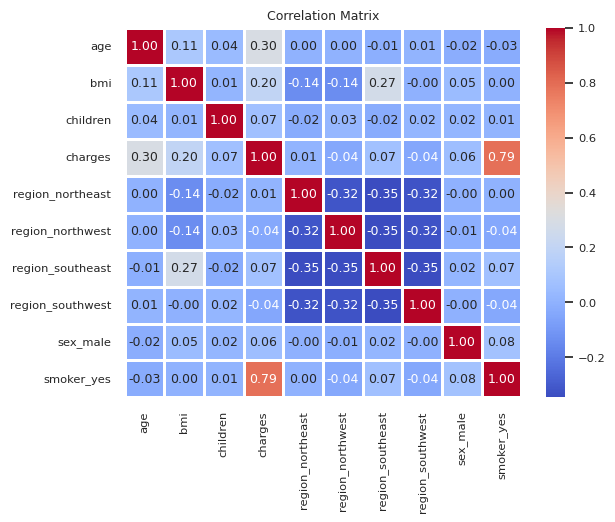

In [10]:
df_aux = df.copy()

df_aux = pd.get_dummies(df, columns=['region', 'sex', 'smoker'], drop_first=False).astype(int)
df_aux = df_aux.drop(columns=['smoker_no', 'sex_female']) #Dropping irrelevant information for creating correlation matrix
aux_numerical_cols, aux_categorical_cols = my_utils.split_numerical_categorical_cols(df_aux)

cm = np.corrcoef(df_aux[aux_numerical_cols].values.T)
sns.set(font_scale=0.75)
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, yticklabels=aux_numerical_cols, xticklabels=aux_numerical_cols)
plt.title('Correlation Matrix')
plt.show()

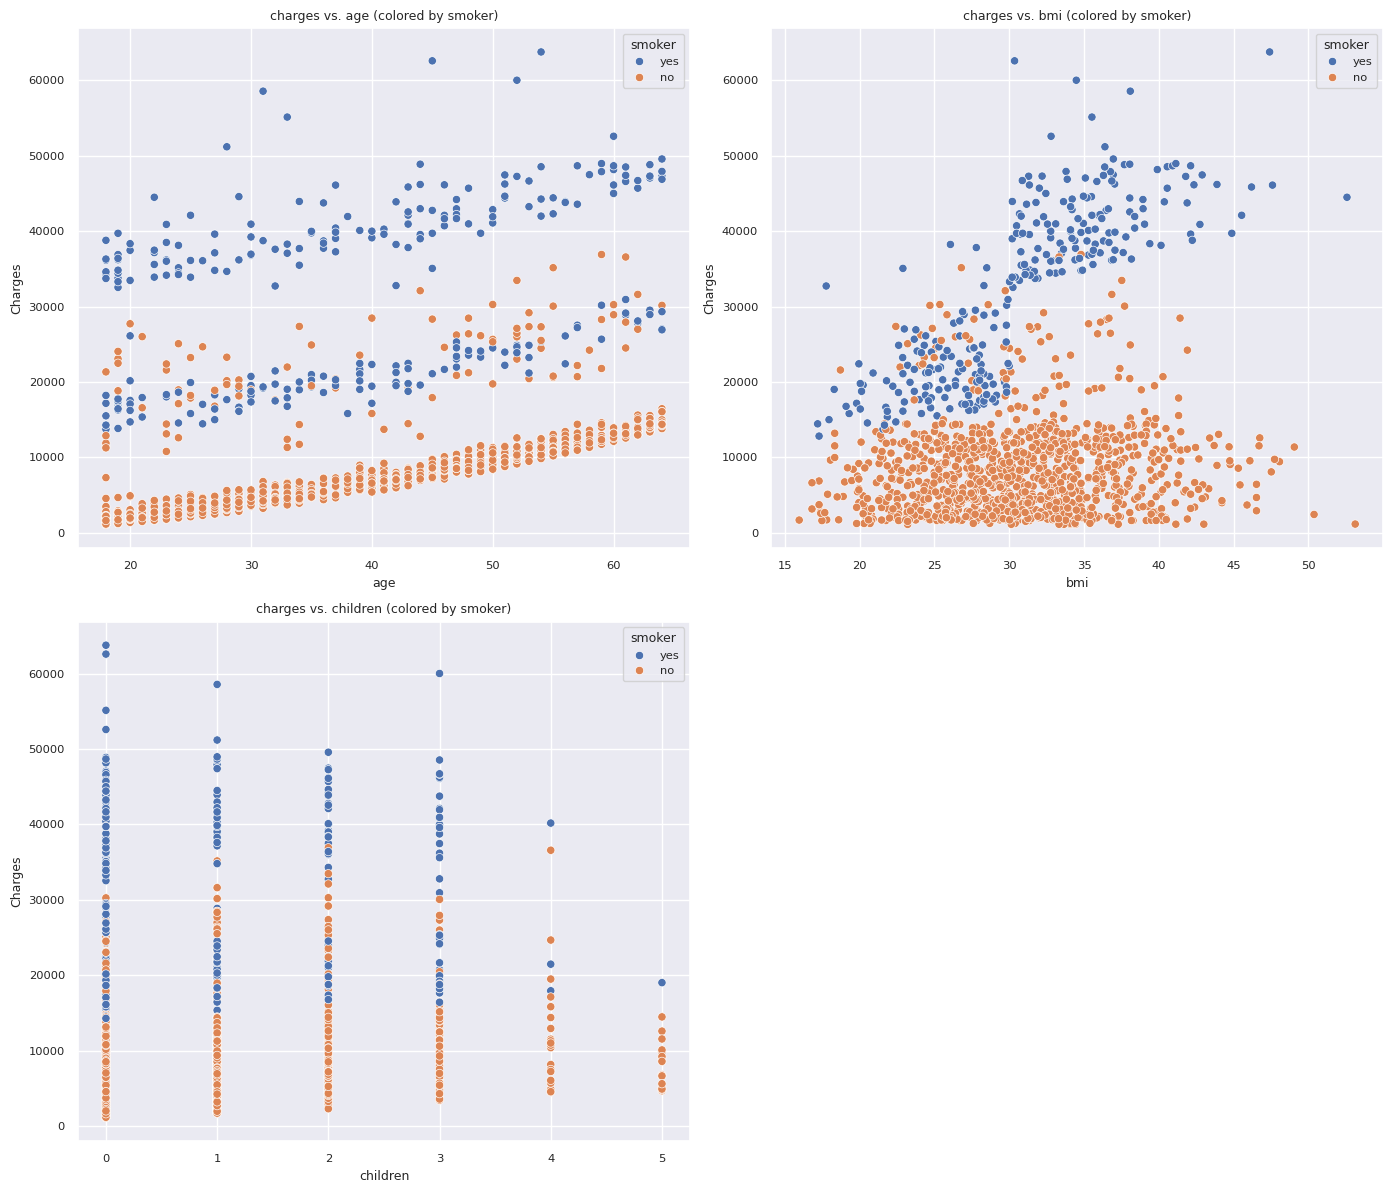

In [11]:
my_utils.plot_scatter_relation_1toN_separated_with_categorical(df, 'charges', 'smoker', columns=['age', 'bmi', 'children'])

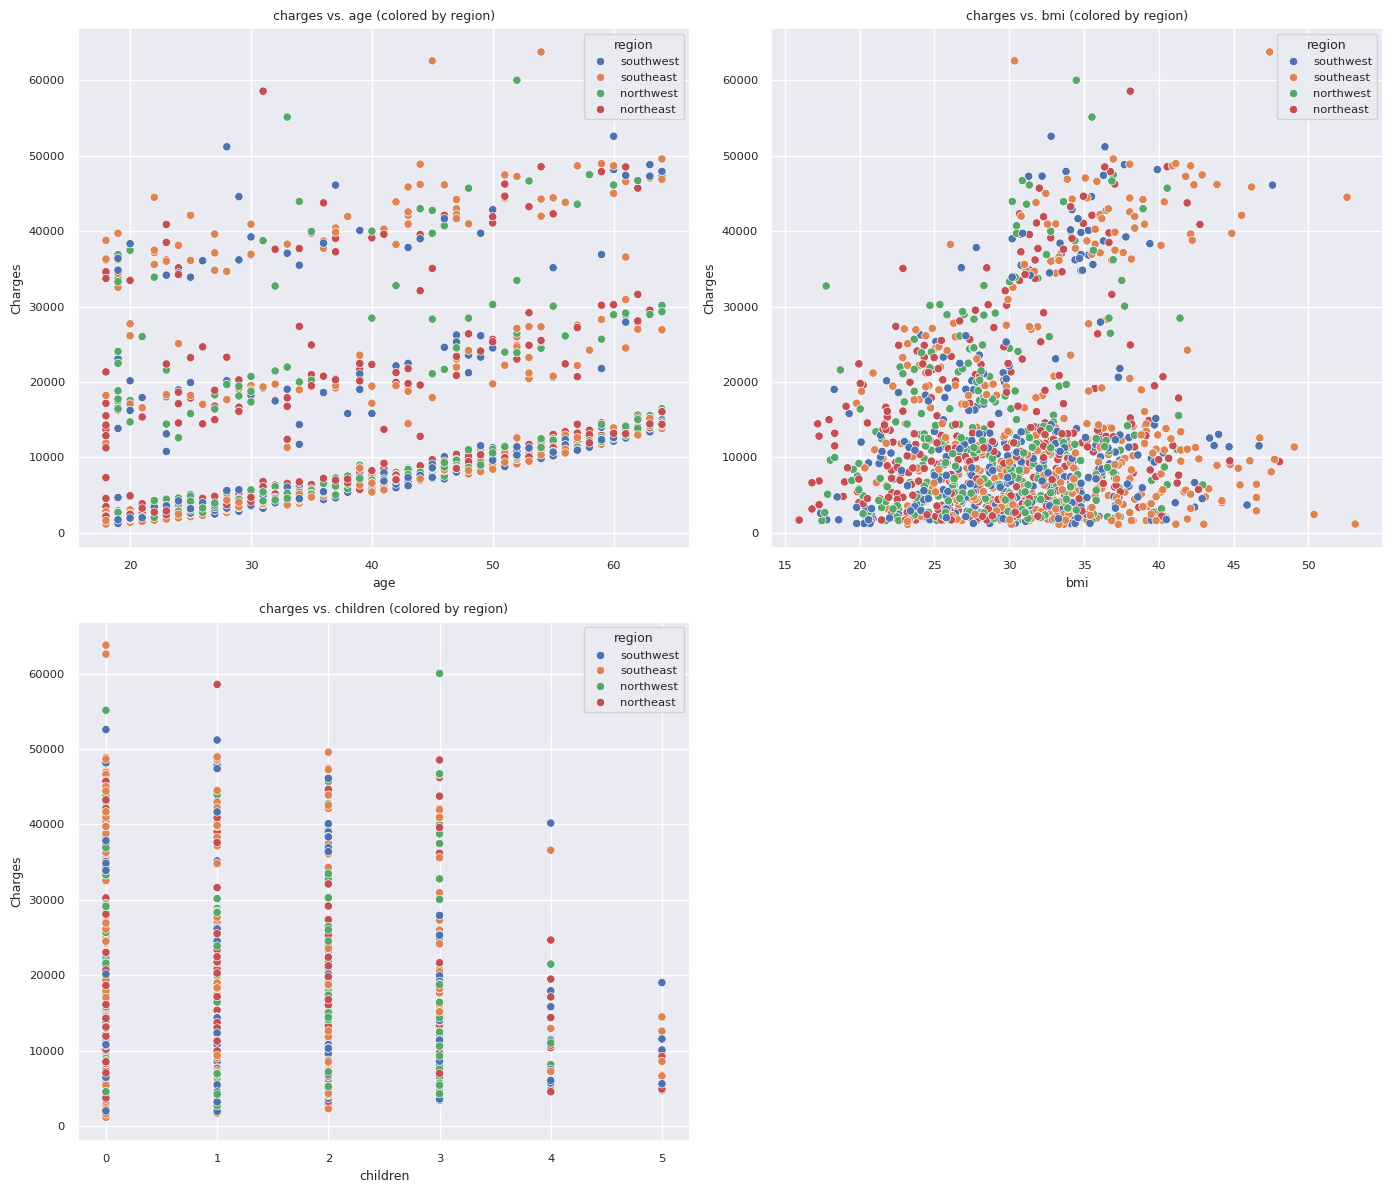

In [12]:
my_utils.plot_scatter_relation_1toN_separated_with_categorical(df, 'charges', 'region', columns=['age', 'bmi', 'children'])

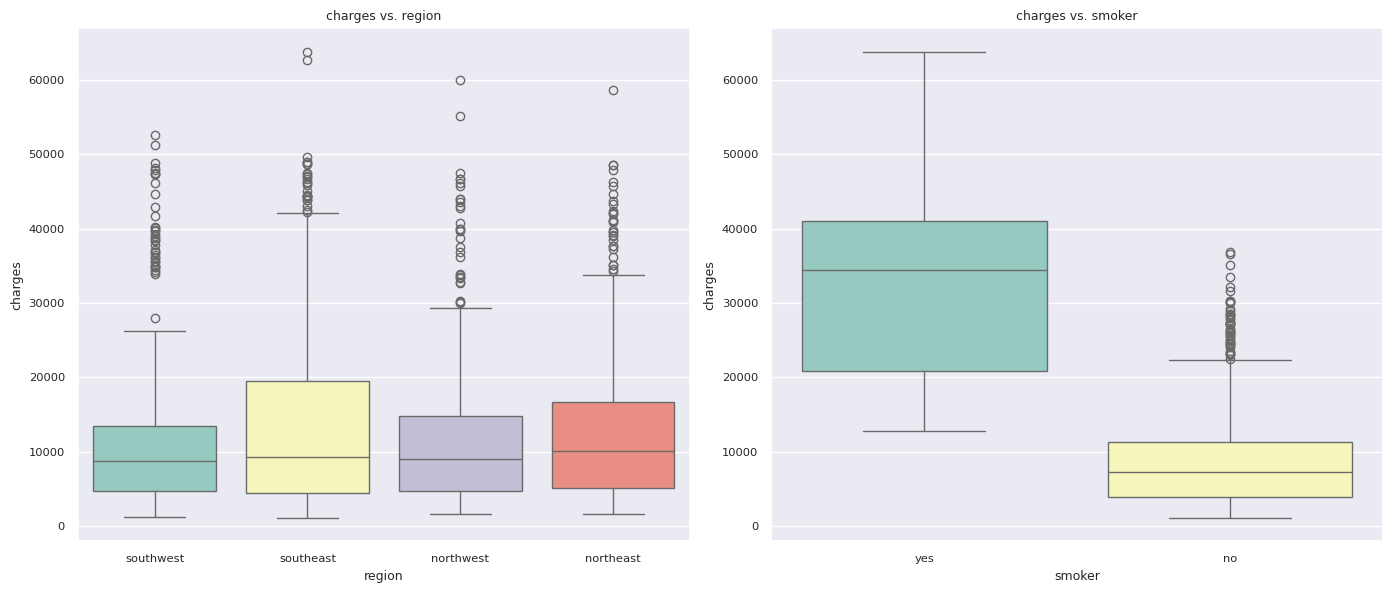

In [13]:
my_utils.plot_boxplot_relation_1toN_separated(df, 'charges', columns=['region', 'smoker',])

## Conclusions for this part
### Correlation matrix:
- Charges (variable to be predicted): Being smoker is highly correlated. Age and BMI are also correlated, but not as much as being smoker.
- Bmi: There is also a significative correlation with some regions, specially with the southweast region. It also has a small correlation with age.

### Scatter plots:
- Charges seems to grow with age, specially for smokers.
- Higher BMI values tend to be associated with higher charges, but seems to be only for smokers and non-smokers maintain their charges in a delimited range.
- Charges shows a decreasing trend when the number of children grows, but again non-smokers have less charges than smokers.
- In all comparisons, smokers incur higher charges than non-smokers.

### Box plots:
- The median charge for smokers is substantially higher, and there is a wider range of charges for smokers.
- Charges vary across different regions, but is not as pronounced as smoker.
- The southeast region seems to have a higher median charge than the other regions.


## Feature engineering

It's time to create new features that might improve the predictive power of the model.

In [14]:
df_feature_eng = df.copy()

df_feature_eng['age_group'] = pd.cut(df_feature_eng['age'], bins=[0, 30, 50, 100], labels=['age_younger', 'age_adult', 'age_senior'])
df_feature_eng['bmi_category'] = pd.cut(df_feature_eng['bmi'], bins=[0, 18.5, 24.9, 29.9, 39.9, 100], labels=['bmi_underweight', 'bmi_healthy', 'bmi_overweight', 'bmi_obesity', 'bmi_severe_obesity'])
df_feature_eng['smoker_bmi'] = df_feature_eng['bmi'] * (df_feature_eng['smoker'] == 'yes')
df_feature_eng['smoker_age'] = df_feature_eng['age'] * (df_feature_eng['smoker'] == 'yes')

In [15]:
numerical_cols, categorical_cols = my_utils.split_numerical_categorical_cols(df_feature_eng)
for column in numerical_cols:
  my_utils.calculate_elasticity(df_feature_eng, column, 'charges')

age elasticity of charges (dependent): 0.7598
bmi elasticity of charges (dependent): 0.9095
children elasticity of charges (dependent): 0.0559
smoker_bmi elasticity of charges (dependent): 0.3812
smoker_age elasticity of charges (dependent): 0.3386


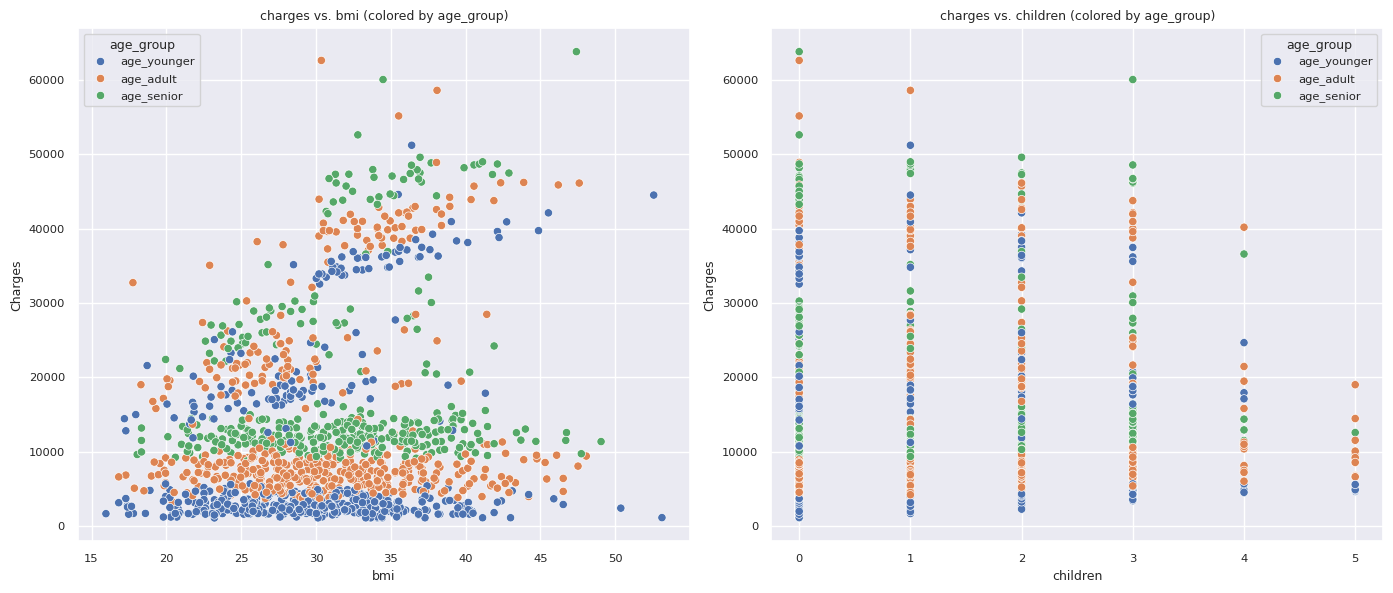

In [16]:
my_utils.plot_scatter_relation_1toN_separated_with_categorical(df_feature_eng, 'charges', 'age_group', columns=['bmi', 'children'])

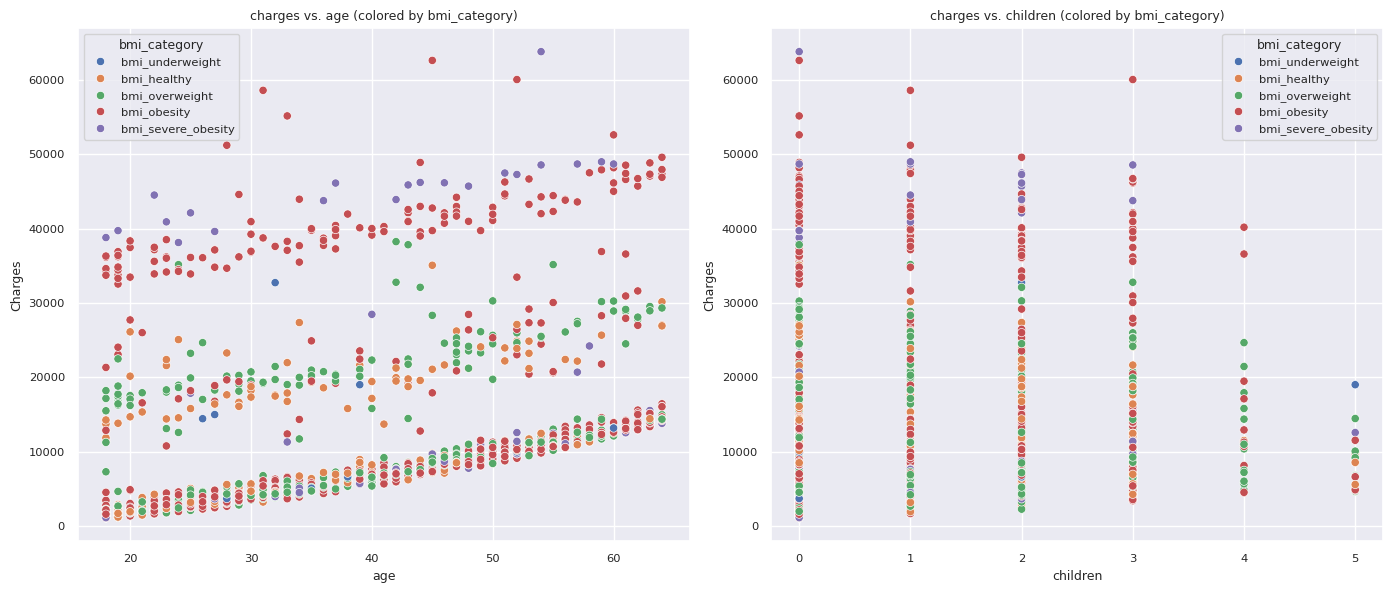

In [17]:
my_utils.plot_scatter_relation_1toN_separated_with_categorical(df_feature_eng, 'charges', 'bmi_category', columns=['age', 'children'])

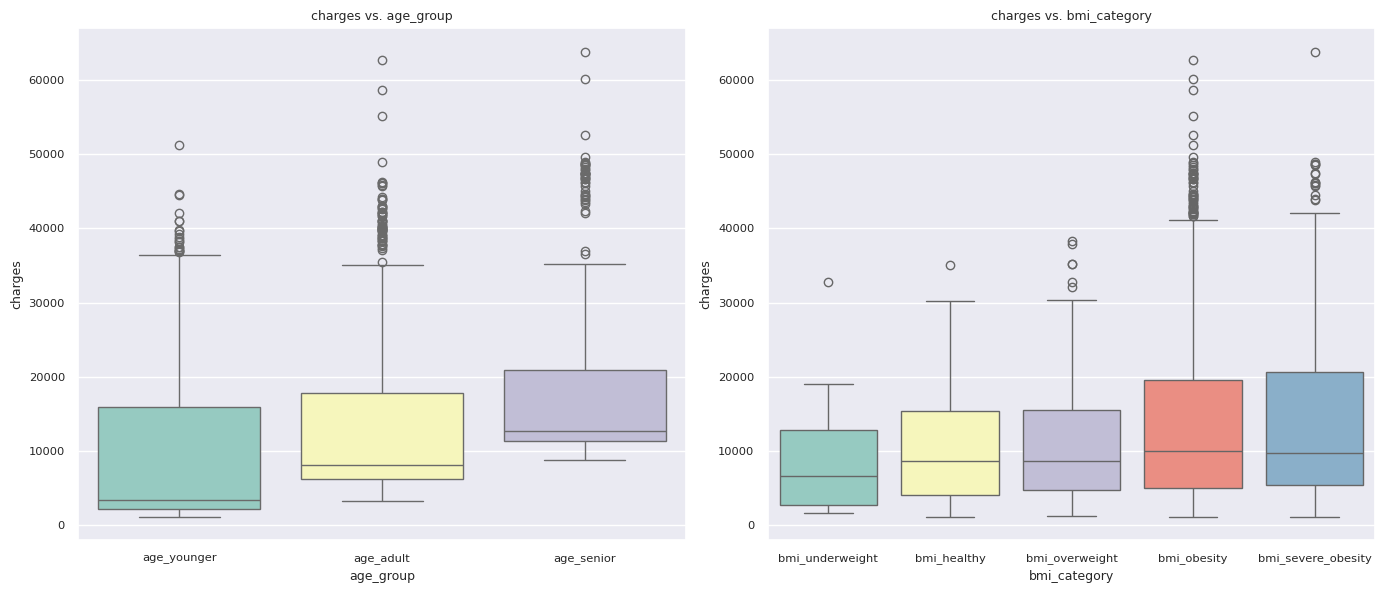

In [18]:
my_utils.plot_boxplot_relation_1toN_separated(df_feature_eng, 'charges', columns=['age_group', 'bmi_category'])

In [19]:
print('Range count -> ', df_feature_eng['age_group'].value_counts())
print('Range count -> ', df_feature_eng['bmi_category'].value_counts())

Range count ->  age_group
age_adult      538
age_younger    443
age_senior     356
Name: count, dtype: int64
Range count ->  bmi_category
bmi_obesity           622
bmi_overweight        380
bmi_healthy           221
bmi_severe_obesity     93
bmi_underweight        21
Name: count, dtype: int64


## Conclusions for this part
- Elasticity: Related to our variable to be predicted, both age and bmi seems to be more relevant in terms of how responsible are to changes in charges, being children specially irrelevant.

- Bmi: There is also a significative correlation with some regions, specially with the southweast region. It also has a small correlation with age.

- Categorical variable 'age_group' shows that there are almost a third part of people that are in younger age. In contrast, there are significatively more people in adult age, and therefore less people in senior age.

- Categorical variable 'bmi_group' are really unbalanced. Has a lot of people with obesity and overweight, a normal count of people healthy and few people at the extremes.

### Scatter plots:
- Charges seems to grow with age, specially for smokers.

- Higher BMI values tend to be associated with higher charges, but seems to be only for smokers and non-smokers maintain their charges in a delimited range.

- Charges shows a decreasing trend when the number of children grows, but again non-smokers have less charges than smokers.

- In all comparisons, smokers incur higher charges than non-smokers.

### Box plots:
- The median charge for smokers is substantially higher, and there is a wider range of charges for smokers.

- Charges vary across different regions, but is not as pronounced as smoker.

- The southeast region seems to have a higher median charge than the other regions, taking into account that we have more entries for this region than the others.


# Models creation













Residuals: Shown differences between the observed values and the values predicted by the model. Residuals indicate how well the model fits the data. The residuals help you understand the spread and distribution of errors. Ideally, residuals should be close to zero, which would indicate that the model's predictions are accurate.

Coefficientes have the key information about the model's estimates for each feature (independent variable), their statistical significance, and their impact on the target variable (dependent variable).
-  It shows the change in the target variable (e.g., charges) for a one-unit change in the feature, holding other variables constant.
-  The standard error of the estimated coefficient. This tells us how much variability is associated with the estimate. A smaller standard error means the estimate is more precise.
- The ratio of the estimated coefficient to its standard error (i.e., Estimate / Std. Error). A larger t value indicates that the estimate is far from zero and more likely to be statistically significant.
- The probability that the coefficient is significantly different from zero (null hypothesis). The smaller the p-value, the more statistically significant the feature [less than 0.05 is significant]

R-squared: Represents the proportion of variance in the target variable that is explained by the model.

Adjusted R-squared: Adjusts the R-squared value based on the number of predictors in the model, penalizing for adding irrelevant features

F-statistic: Tests the overall significance of the model. A high F-statistic suggests that the model as a whole is statistically significant, meaning at least one predictor variable is significantly related to the target variable. The F-statistic compares the model with and without the predictors.

## Model 1: Initial dataset cleaned

For that, we can use our initial dataframe and applying one-hot encoding for see what's our first result training a model, seeing how good the model make predictions.


==== Summary ====

Residuals:
    Min      1Q  Median     3Q    Max
-1.9907 -0.1494  0.0761 0.2223 0.8659


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.007070    0.030300  -0.2333  0.815673
children          0.053201    0.029448   1.8066  0.071945
region_northwest -0.013704    0.035531  -0.3857  0.700035
age               0.288078    0.029721   9.6927  0.000000
bmi               0.160594    0.030545   5.2577  0.000000
region_southeast -0.031304    0.034884  -0.8974  0.370326
region_southwest -0.023983    0.035613  -0.6734  0.501258
sex_male         -0.004174    0.030502  -0.1368  0.891258
smoker_yes        0.769814    0.029263  26.3064  0.000000
---
R-squared:  0.80694,    Adjusted R-squared:  0.80098
F-statistic: 135.32 on 8 features


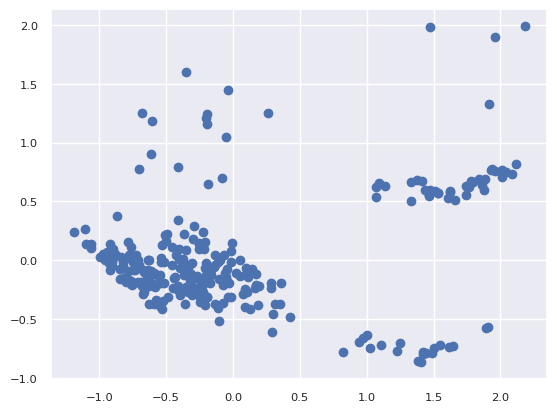

Regression Model Summary:
Prediction shape --> (268, 1)
Mean Absolute Error (MAE): 0.3446
Mean Squared Error (MSE): 0.2421
Root Mean Squared Error (RMSE): 0.4920
Mean Absolute Percentage Error (MAPE): 367.40%
R-squared: 0.8069
Adjusted R-squared: 0.8010
Cross-Validated R-squared: 0.8012
AIC: 1706.9197
BIC: 1739.2386


In [20]:
df_first = df.copy()
df_first = pd.get_dummies(df_first, columns=['region', 'smoker', 'sex'], drop_first=True).astype(int)

x_cols = list(set(df_first.columns)-set(['charges']))
y_col = ['charges']

x_train, x_test, y_train, y_test, y_pred, model_first = my_utils.get_predictions_and_initial_score(df_first, x_cols, y_col)
metrics_df = my_utils.regression_summary(y_test, y_pred, x_test, model_first)

In this first model, we can see the coefficients in order to highlight the columns that are more relevant for the model. Seem to be that smoker, age and bmi are the most relevant columns to predict the insurance cost.

## Model 2: Filtering non relevant information from 1


==== Summary ====

Residuals:
    Min      1Q  Median     3Q    Max
-2.0069 -0.1495  0.0643 0.2262 0.8323


Coefficients:
            Estimate  Std. Error  t value   p value
_intercept -0.007449    0.030343  -0.2455  0.806260
smoker_yes  0.768603    0.029376  26.1644  0.000000
children    0.053710    0.029265   1.8353  0.067576
age         0.289230    0.029898   9.6737  0.000000
bmi         0.153598    0.029520   5.2031  0.000000
---
R-squared:  0.80452,    Adjusted R-squared:  0.80154
F-statistic: 270.60 on 4 features


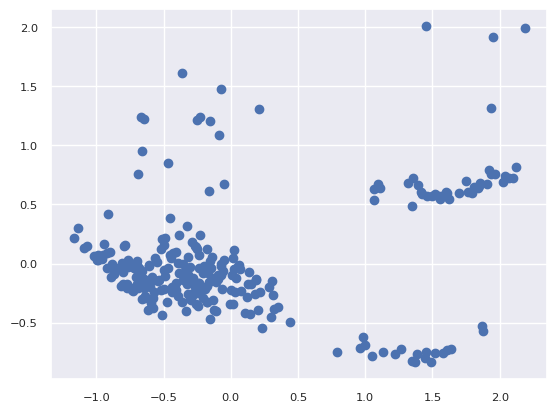

Regression Model Summary:
Prediction shape --> (268, 1)
Mean Absolute Error (MAE): 0.3465
Mean Squared Error (MSE): 0.2451
Root Mean Squared Error (RMSE): 0.4951
Mean Absolute Percentage Error (MAPE): 367.29%
R-squared: 0.8045
Adjusted R-squared: 0.8015
Cross-Validated R-squared: 0.8005
AIC: 1698.7778
BIC: 1716.7327


In [21]:
df_second = df_first.copy()

x_cols = ['smoker_yes', 'children', 'age', 'bmi']
y_col = ['charges']

x_train, x_test, y_train, y_test, y_pred, model_second = my_utils.get_predictions_and_initial_score(df_second, x_cols, y_col)
metrics_df = my_utils.regression_summary(y_test, y_pred, x_test, model_second)

## Model 3: Applying feature engineering

In [22]:
df_third = df.copy()

# Binary encoding for 'sex' and 'smoker'
df_third['sex_encoded'] = df_third['sex'].map({'male': 1, 'female': 0})
df_third['smoker_encoded'] = df_third['smoker'].map({'yes': 1, 'no': 0})

# Interaction features
df_third['age_bmi'] = df_third['age'] * df_third['bmi']
df_third['smoker_bmi'] = df_third['bmi'] * (df_third['smoker'] == 'yes')
df_third['smoker_age'] = df_third['age'] * (df_third['smoker'] == 'yes')
df_third['health_risk'] = ((df_third['bmi'] >= 30) & (df_third['smoker_encoded'] == 1)).astype(int)

# Binning for 'age' and 'bmi'
df_third['age_group'] = pd.cut(df_third['age'], bins=[0, 30, 50, 100], labels=['age_younger', 'age_adult', 'age_senior'])
df_third['bmi_category'] = pd.cut(df_third['bmi'], bins=[0, 18.5, 24.9, 29.9, 39.9, 100], labels=['bmi_underweight', 'bmi_healthy', 'bmi_overweight', 'bmi_obesity', 'bmi_severe_obesity'])

# Delete unuseful columns and one-hot encoding for needed columns
df_third = df_third.drop(columns=['sex', 'smoker'])
df_third = pd.get_dummies(df_third, columns=['region', 'age_group', 'bmi_category'], drop_first=True).astype(int)

numerical_cols, categorical_cols = my_utils.split_numerical_categorical_cols(df_third)
for columns in numerical_cols:
  my_utils.calculate_elasticity(df_third, columns, 'charges')

age elasticity of charges (dependent): 0.7598
bmi elasticity of charges (dependent): 0.8820
children elasticity of charges (dependent): 0.0559
sex_encoded elasticity of charges (dependent): 0.0534
smoker_encoded elasticity of charges (dependent): 0.3644
age_bmi elasticity of charges (dependent): 0.7068
smoker_bmi elasticity of charges (dependent): 0.3811
smoker_age elasticity of charges (dependent): 0.3386
health_risk elasticity of charges (dependent): 0.2591
region_northwest elasticity of charges (dependent): -0.0200
region_southeast elasticity of charges (dependent): 0.0410
region_southwest elasticity of charges (dependent): -0.0225
age_group_age_adult elasticity of charges (dependent): 0.0001
age_group_age_senior elasticity of charges (dependent): 0.1313
bmi_category_bmi_healthy elasticity of charges (dependent): -0.0429
bmi_category_bmi_overweight elasticity of charges (dependent): -0.0679
bmi_category_bmi_obesity elasticity of charges (dependent): 0.1349
bmi_category_bmi_severe_ob


==== Summary ====

Residuals:
    Min     1Q  Median     3Q    Max
-1.5404 0.0469  0.1012 0.1347 0.2405


Coefficients:
                                 Estimate  Std. Error  t value   p value
_intercept                       0.000627    0.020975   0.0299  0.976175
smoker_bmi                       0.534130    0.132144   4.0420  0.000069
bmi                             -0.000938    0.061869  -0.0152  0.987916
bmi_category_bmi_healthy         0.040528    0.042569   0.9521  0.341932
smoker_encoded                   0.022075    0.111108   0.1987  0.842663
bmi_category_bmi_overweight      0.037548    0.054281   0.6917  0.489699
sex_encoded                     -0.023671    0.021216  -1.1157  0.265550
region_southwest                -0.039898    0.024962  -1.5983  0.111152
smoker_age                      -0.010702    0.054432  -0.1966  0.844275
age_group_age_adult             -0.068468    0.035308  -1.9392  0.053536
children                         0.069205    0.020824   3.3234  0.001014
age

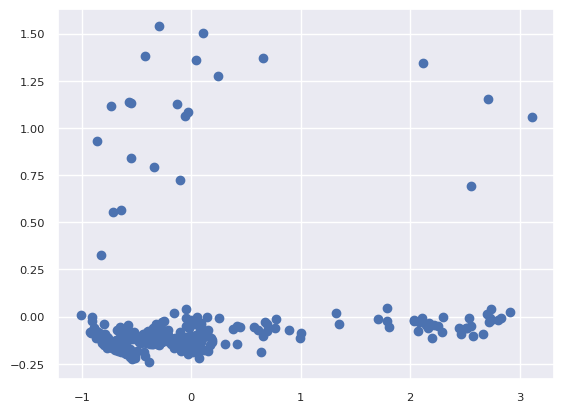

Regression Model Summary:
Prediction shape --> (268, 1)
Mean Absolute Error (MAE): 0.1844
Mean Squared Error (MSE): 0.1149
Root Mean Squared Error (RMSE): 0.3390
Mean Absolute Percentage Error (MAPE): 383.09%
R-squared: 0.9083
Adjusted R-squared: 0.9017
Cross-Validated R-squared: 0.8872
AIC: 1760.2308
BIC: 1828.4596


In [23]:
x_cols = list(set(df_third.columns)-set(['charges']))
y_col = ['charges']
x_train, x_test, y_train, y_test, y_pred, model_third = my_utils.get_predictions_and_initial_score(df_third, x_cols, y_col)
metrics_df = my_utils.regression_summary(y_test, y_pred, x_test, model_third)

## Model 4: Filtering non relevant information from 3


==== Summary ====

Residuals:
    Min     1Q  Median     3Q   Max
-1.5228 0.0415  0.0967 0.1444 0.213


Coefficients:
             Estimate  Std. Error  t value   p value
_intercept   0.000310    0.020920   0.0148  0.988205
health_risk  0.371881    0.031189  11.9233  0.000000
children     0.057011    0.020138   2.8310  0.004994
smoker_bmi   0.545218    0.032651  16.6982  0.000000
age          0.303189    0.020583  14.7303  0.000000
---
R-squared:  0.90726,    Adjusted R-squared:  0.90585
F-statistic: 643.19 on 4 features


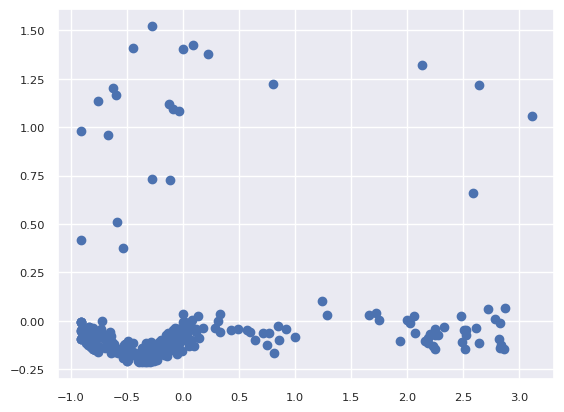

Regression Model Summary:
Prediction shape --> (268, 1)
Mean Absolute Error (MAE): 0.1852
Mean Squared Error (MSE): 0.1163
Root Mean Squared Error (RMSE): 0.3410
Mean Absolute Percentage Error (MAPE): 381.38%
R-squared: 0.9073
Adjusted R-squared: 0.9058
Cross-Validated R-squared: 0.8961
AIC: 1733.9341
BIC: 1751.8890


In [24]:
df_fourth = df_third.copy()

x_cols = ['health_risk', 'children', 'smoker_bmi', 'age']
y_col = ['charges']
x_train, x_test, y_train, y_test, y_pred, model_fourth = my_utils.get_predictions_and_initial_score(df_third, x_cols, y_col)
metrics_df = my_utils.regression_summary(y_test, y_pred, x_test, model_fourth)

# Performance of the models

Comparing both models (after filtering each one), that's the progression:

- Mean Absolute Error (MAE): 0.3465 --> 0.1852
- Mean Squared Error (MSE): 0.2451 --> 0.1163
- Root Mean Squared Error (RMSE): 0.4951 --> 0.3410
- Mean Absolute Percentage Error (MAPE): 367.29% --> 381.38%
- R-squared: 0.8045 --> 0.9073
- Adjusted R-squared: 0.8015 --> 0.9058
- Cross-Validated R-squared: 0.8005 --> 0.8961
- AIC: 1698.7778 --> 1733.9341
- BIC: 1716.7327 --> 1751.8890

### Main insights of the result of the metrics:

Metrics related to errors (difference between real and predicted values) it is obvious that the final model offers a huge improvement. Based on MSE specially, the model is also few sensitive to outliers.

Metrics related to R-squared (proportion of variance in the target variable), the final model has also a remarkable improvement. Based on Cross-Validated metric, the final model has also a better stability in terms of performance across different subsets of data.



# Models test

For testing, I created a couple of small datasets, one with normal values and one with edge cases. By doing this, we can check if our models work as expected.

In [25]:
test_cases_first = pd.DataFrame({
    'age': [25, 40, 60, 30, 35],  # Variety of ages, testing different life stages
    'bmi': [22.0, 30.5, 27.8, 35.0, 26.2],  # Low, average, high BMI values
    'children': [0, 1, 3, 2, 0],  # Different numbers of children
    'smoker_yes': [0, 1, 0, 1, 0],  # Testing smoker and non-smoker
})

test_cases_second = test_cases_first.copy() # For the model with feature engineering
test_cases_second['smoker_bmi'] = test_cases_second['bmi'] * (test_cases_second['smoker_yes'] == 1)
test_cases_second['health_risk'] = ((test_cases_second['bmi'] >= 30) & (test_cases_second['smoker_yes'] == 1)).astype(int)
test_cases_second = test_cases_second.drop(columns=['smoker_yes', 'bmi'])

predictions_normal_first = model_second.predict(test_cases_first)
test_cases_first['predicted_charges'] = predictions_normal_first
print('Common test cases for the initial model filtered:')
print(test_cases_first[['age', 'bmi', 'children', 'smoker_yes', 'predicted_charges']])

predictions_normal_second = model_fourth.predict(test_cases_second)
test_cases_second['predicted_charges'] = predictions_normal_second
print('Common test cases for the final model filtered:')
print(test_cases_second[['health_risk', 'children', 'smoker_bmi', 'age', 'predicted_charges']])

Common test cases for the initial model filtered:
   age   bmi  children  smoker_yes  predicted_charges
0   25  22.0         0           0          20.389247
1   40  30.5         1           1          32.817657
2   60  27.8         3           0          48.469570
3   30  35.0         2           1          25.662547
4   35  26.2         0           0          28.300861
Common test cases for the final model filtered:
   health_risk  children  smoker_bmi  age  predicted_charges
0            0         0         0.0   25           9.297337
1            1         1        30.5   40          31.864893
2            0         3         0.0   60          22.484208
3            1         2        35.0   30          30.656572
4            0         0         0.0   35          13.016149


In [26]:
edge_cases_first = pd.DataFrame({
    'age': [20, 70, 19, 77, 23], # High and low age for testing
    'bmi': [40.0, 18.5, 50.0, 15.0, 54.0],  # Extremely high and low BMI values
    'children': [0, 5, 2, 0, 4],  # High number of children for testing
    'smoker_yes': [1, 0, 1, 0, 1],  # Young smoker vs. older non-smoker
})

edge_cases_second = edge_cases_first.copy()
edge_cases_second['smoker_bmi'] = edge_cases_second['bmi'] * (edge_cases_second['smoker_yes'] == 1)
edge_cases_second['health_risk'] = ((edge_cases_second['bmi'] >= 30) & (edge_cases_second['smoker_yes'] == 1)).astype(int)
edge_cases_second = edge_cases_second.drop(columns=['smoker_yes', 'bmi'])

predictions_edge_first = model_second.predict(edge_cases_first)
edge_cases_first['predicted_charges'] = predictions_edge_first
print('Edge test cases for the initial model filtered:')
print(edge_cases_first[['age', 'bmi', 'children', 'smoker_yes', 'predicted_charges']])

predictions_edge_second = model_fourth.predict(edge_cases_second)
edge_cases_second['predicted_charges'] = predictions_edge_second
print('Common test cases for the final model filtered:')
print(edge_cases_second[['health_risk', 'children', 'smoker_bmi', 'age', 'predicted_charges']])

Edge test cases for the initial model filtered:
   age   bmi  children  smoker_yes  predicted_charges
0   20  40.0         0           1          17.666602
1   70  18.5         5           0          56.234563
2   19  50.0         2           1          18.013556
3   77  15.0         0           0          59.980653
4   23  54.0         4           1          21.881268
Common test cases for the final model filtered:
   health_risk  children  smoker_bmi  age  predicted_charges
0            1         0        40.0   20          29.549829
1            0         5         0.0   70          26.317040
2            1         2        50.0   19          34.744145
3            0         0         0.0   77          28.635155
4            1         4        54.0   23          38.526562


Based on the results of this small tests, it is clear that using the model with feature engineering offers better predictions in both type of test.


- In common tests, it is clear how the results fit better with the observations made in the EDA phase. Being smoker has more impact based on the nature of the information used. Children has fewer impact.


- In edge test, it is striking how the results are not extreme when the values ​​are very atypical.